In [16]:
from Algorithm import Gaussian_Process
from Algorithm import LA_Bayessian_Quadrature
from Algorithm import Mesh
from Algorithm import Kernels
import Target_Function as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
from scipy.stats import uniform

plt.rcParams['figure.figsize'] = [12, 6]


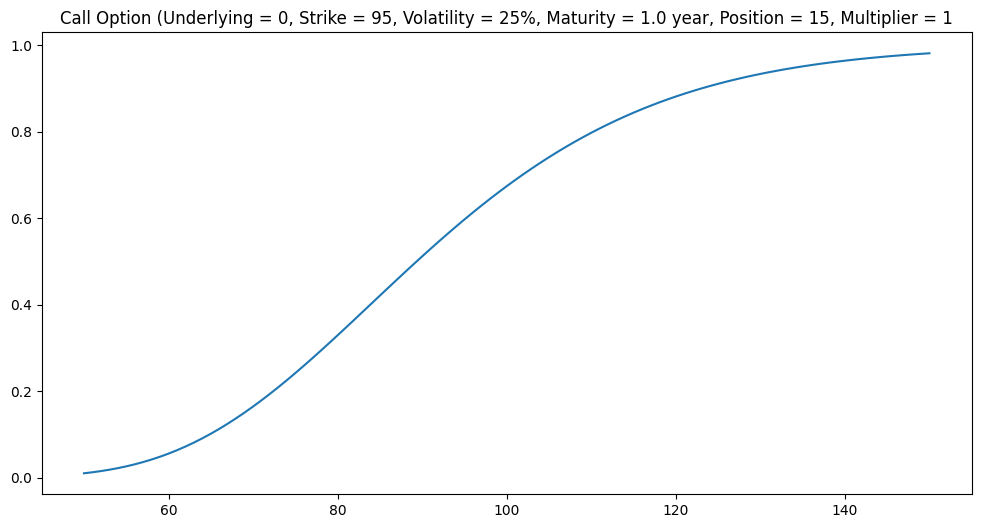

In [17]:
opt1 = tf.Option('call', 0, 95, 0.25, 1.0,  15, 1)
portfolio = tf.OptionPortfolio(0.03, 50, 150, [opt1])
func = portfolio.target_function
a = np.linspace(50, 150, 101)
b = np.zeros_like(a)
for i in range(101):
    b[i] = func(portfolio.alter(a[i]))
plt.plot(a,b)
X = np.around(np.array(np.meshgrid(np.linspace(0,1,11), indexing='ij')).reshape(1,-1).T,1)
Y = []
plt.title('Call Option (Underlying = 0, Strike = 95, Volatility = 25%, Maturity = 1.0 year, Position = 15, Multiplier = 1)')

plt.show()

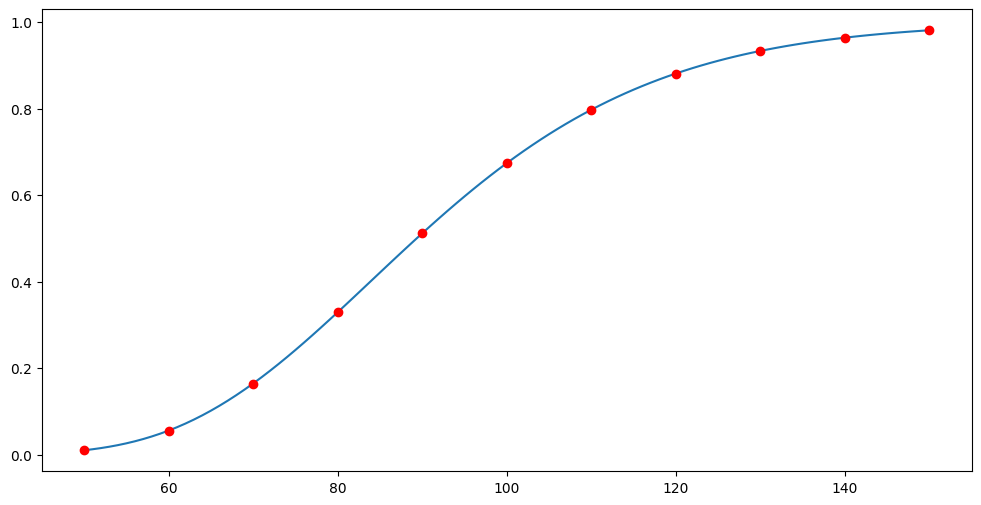

In [18]:
a = np.linspace(50, 150, 101)
b = np.zeros_like(a)
for i in range(101):
    b[i] = func(portfolio.alter(a[i]))
plt.plot(a,b)
X = np.around(np.array(np.meshgrid(np.linspace(0,1,11), indexing='ij')).reshape(1,-1).T,1)
Y = []
for i in range(11):
    Y.append(func(X[i]))
    plt.plot(portfolio.to_initial(X[i]),Y[i],'ro')

plt.show()

In [19]:
beta = np.concatenate([
    np.array([-0.5]),
    np.random.uniform(-2, 0, size=11)
])

In [20]:
GP = Gaussian_Process.GaussianProcess(Kernels.K_lin_mat2_10,beta,X,Y) # Define Gaussian process

In [21]:
GPs_mat1,int_params_mat1 = LA_Bayessian_Quadrature.LABQ(func,GP,Mesh.get_points,30,[30,1])


Step:  1  /  31
Step:  2  /  31
Step:  3  /  31
Step:  4  /  31
Step:  5  /  31
Step:  6  /  31
Step:  7  /  31
Step:  8  /  31
Step:  9  /  31
Step:  10  /  31
Step:  11  /  31
Step:  12  /  31
Step:  13  /  31
Step:  14  /  31
Step:  15  /  31
Step:  16  /  31
Step:  17  /  31
Step:  18  /  31
Step:  19  /  31
Step:  20  /  31
Step:  21  /  31
Step:  22  /  31
Step:  23  /  31
Step:  24  /  31
Step:  25  /  31
Step:  26  /  31
Step:  27  /  31
Step:  28  /  31
Step:  29  /  31
Step:  30  /  31
Step:  31  /  31


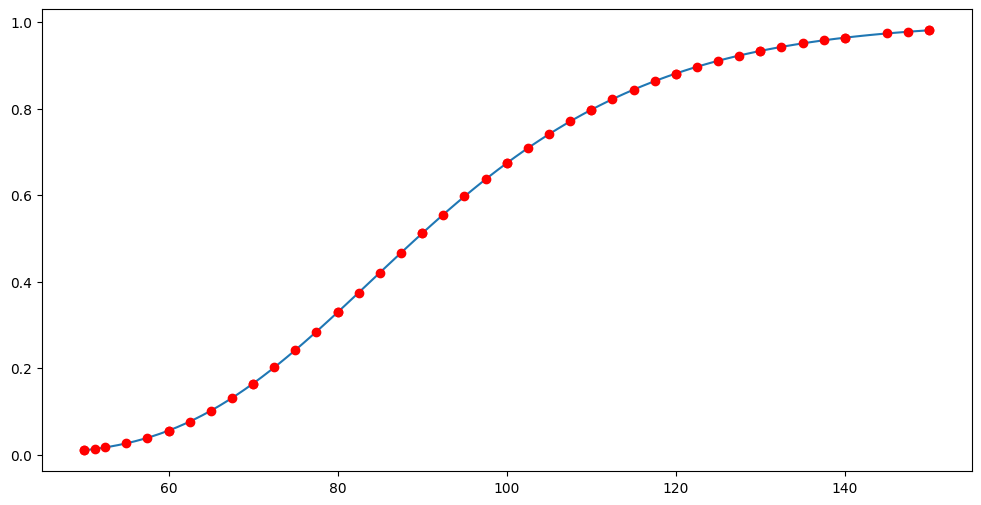

In [28]:
final_GP = GPs_mat1[-1]
a = np.linspace(50, 150, 101)
b = np.zeros_like(a)
for i in range(101):
    b[i] = func(portfolio.alter(a[i]))
plt.plot(a,b)
X = np.around(np.array(np.meshgrid(np.linspace(0,1,11), indexing='ij')).reshape(1,-1).T,1)
Y = []
for i in range(11):
    Y.append(func(X[i]))
    plt.plot(portfolio.to_initial(X[i]),Y[i],'ro')

px = final_GP.X.T[0]
py = [func(i) for i in px]

for i in range(len(px)):
    plt.plot(portfolio.to_initial(px[i]),py[i],'ro')
plt.show()


In [27]:
print("Calculated value =", int_params_mat1[-1])

# Monte Carlo 积分估计
def monte_carlo_integration(f, lower=0, upper=1, num_samples=100000):
    X = np.random.uniform(lower, upper, size=(num_samples, 1))
    Y = np.array([f(x) for x in X])
    mean = Y.mean()
    var = Y.var() / num_samples
    return mean, var

# 使用同样的 func
mc_mean, mc_var = monte_carlo_integration(func)
print("Monte Carlo Result =", [float(mc_mean), float(mc_var)])

Calculated value = [5.80542024e-01 5.18223860e-10]
Monte Carlo Result = [0.5795850900368886, 1.1732594342431483e-06]
